In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries berhasil di-import!")

✅ Libraries berhasil di-import!


In [2]:
print("="*80)
print("LOADING DATA DAN METADATA")
print("="*80)

# Load dataset asli
df = pd.read_csv('../data/raw/DATA (1).csv')
print(f"✅ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Load metadata dari EDA
with open('../data/processed/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

target_col = metadata['target_column']
print(f"✅ Target column: '{target_col}'")
print(f"✅ Total features: {metadata['total_features']}")

# Tampilkan informasi awal
print(f"\n📊 Dataset Info:")
print(f"  • Shape: {df.shape}")
print(f"  • Target: {target_col}")
print(f"  • Classes: {df[target_col].unique()}")


LOADING DATA DAN METADATA
✅ Dataset loaded: 145 rows, 33 columns
✅ Target column: 'GRADE'
✅ Total features: 32

📊 Dataset Info:
  • Shape: (145, 33)
  • Target: GRADE
  • Classes: [1 2 5 0 3 4 7 6]


In [8]:
print("\n" + "="*80)
print("STEP 1: DATA CLEANING - HANDLING MISSING VALUES")
print("="*80)

# Cek missing values
missing_before = df.isnull().sum().sum()
print(f"\n📊 Total missing values: {missing_before}")

if missing_before > 0:
    print("\n⚠️  Missing values detected!")
    missing_info = df.isnull().sum()
    missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
    print("\nKolom dengan missing values:")
    for col, count in missing_info.items():
        percent = (count / len(df)) * 100
        print(f"  • {col}: {count} ({percent:.2f}%)")
    
    # STRATEGY HANDLING MISSING VALUES
    print("\n🔧 Menangani missing values...")
    
    for col in missing_info.index:
        if df[col].dtype == 'object':
            # Kategorikal: isi dengan modus
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"  ✓ {col}: diisi dengan modus '{mode_val}'")
        else:
            # Numerik: isi dengan median (lebih robust terhadap outlier)
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"  ✓ {col}: diisi dengan median {median_val}")
    
    missing_after = df.isnull().sum().sum()
    print(f"\n✅ Missing values setelah cleaning: {missing_after}")
else:
    print("\n✅ Tidak ada missing values!")


STEP 1: DATA CLEANING - HANDLING MISSING VALUES

📊 Total missing values: 0

✅ Tidak ada missing values!


In [9]:
print("\n" + "="*80)
print("STEP 2: DATA CLEANING - HANDLING DUPLICATES")
print("="*80)

duplicates_before = df.duplicated().sum()
print(f"\n📊 Jumlah duplikat: {duplicates_before}")

if duplicates_before > 0:
    print(f"⚠️  Menghapus {duplicates_before} baris duplikat...")
    df_before = df.shape[0]
    df = df.drop_duplicates()
    df_after = df.shape[0]
    print(f"✅ Duplikat dihapus: {df_before} → {df_after} rows")
else:
    print("✅ Tidak ada duplikat!")

# Reset index setelah drop
df.reset_index(drop=True, inplace=True)


STEP 2: DATA CLEANING - HANDLING DUPLICATES

📊 Jumlah duplikat: 0
✅ Tidak ada duplikat!


In [10]:
print("\n" + "="*80)
print("IDENTIFIKASI TIPE VARIABEL")
print("="*80)

# Pisahkan features dan target
X = df.drop(columns=[target_col])
y = df[target_col]

# Identifikasi kolom numerik dan kategorikal
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 Total Features: {X.shape[1]}")
print(f"  • Numerik: {len(numeric_features)} features")
print(f"  • Kategorikal: {len(categorical_features)} features")

print(f"\n📋 Daftar Features Numerik ({len(numeric_features)}):")
for i, col in enumerate(numeric_features, 1):
    print(f"  {i}. {col}")

print(f"\n📋 Daftar Features Kategorikal ({len(categorical_features)}):")
for i, col in enumerate(categorical_features, 1):
    unique_count = X[col].nunique()
    print(f"  {i}. {col} ({unique_count} kategori)")


IDENTIFIKASI TIPE VARIABEL

📊 Total Features: 32
  • Numerik: 31 features
  • Kategorikal: 1 features

📋 Daftar Features Numerik (31):
  1. 1
  2. 2
  3. 3
  4. 4
  5. 5
  6. 6
  7. 7
  8. 8
  9. 9
  10. 10
  11. 11
  12. 12
  13. 13
  14. 14
  15. 15
  16. 16
  17. 17
  18. 18
  19. 19
  20. 20
  21. 21
  22. 22
  23. 23
  24. 24
  25. 25
  26. 26
  27. 27
  28. 28
  29. 29
  30. 30
  31. COURSE ID

📋 Daftar Features Kategorikal (1):
  1. STUDENT ID (145 kategori)


In [11]:
print("\n" + "="*80)
print("STEP 3: ENCODING VARIABEL KATEGORIKAL")
print("="*80)

# STRATEGI ENCODING:
# - Jika kategori adalah ordinal (ada urutan): Label Encoding
# - Jika kategori adalah nominal (tidak ada urutan): One-Hot Encoding
# - Karena dataset mahasiswa biasanya banyak nominal, kita gunakan Label Encoding
#   untuk menghindari curse of dimensionality

print("\n🔧 Menggunakan Label Encoding untuk semua variabel kategorikal...")
print("💡 Alasan: Menghindari high dimensionality & cocok untuk tree-based models\n")

# Buat copy dataframe untuk encoding
X_encoded = X.copy()

# Dictionary untuk menyimpan label encoders
label_encoders = {}

if len(categorical_features) > 0:
    for col in categorical_features:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        
        # Tampilkan mapping
        unique_original = X[col].unique()[:5]  # Tampilkan 5 pertama
        unique_encoded = le.transform(unique_original.astype(str))
        print(f"✓ {col}:")
        print(f"    Original: {unique_original.tolist()}")
        print(f"    Encoded:  {unique_encoded.tolist()}")
        if len(X[col].unique()) > 5:
            print(f"    ... (total {len(X[col].unique())} categories)")
        print()
    
    print(f"✅ {len(categorical_features)} variabel kategorikal berhasil di-encode!")
else:
    print("ℹ️  Tidak ada variabel kategorikal untuk di-encode")


STEP 3: ENCODING VARIABEL KATEGORIKAL

🔧 Menggunakan Label Encoding untuk semua variabel kategorikal...
💡 Alasan: Menghindari high dimensionality & cocok untuk tree-based models

✓ STUDENT ID:
    Original: ['STUDENT1', 'STUDENT2', 'STUDENT3', 'STUDENT4', 'STUDENT5']
    Encoded:  [0, 57, 68, 79, 90]
    ... (total 145 categories)

✅ 1 variabel kategorikal berhasil di-encode!


In [12]:
print("\n" + "="*80)
print("ENCODING TARGET VARIABLE")
print("="*80)

# Encode target variable (GRADE)
print(f"🎯 Target Variable: {target_col}\n")

# Cek apakah target sudah numerik atau masih kategorikal
if y.dtype == 'object' or y.dtype.name == 'category':
    print("Target adalah kategorikal, melakukan encoding...")
    
    # Untuk GRADE, kita perlu ordinal encoding yang benar
    # Mapping grade ke nilai numerik sesuai urutan akademik
    grade_mapping = {
        'Fail': 0,
        'DD': 1,
        'DC': 2,
        'CC': 3,
        'CB': 4,
        'BB': 5,
        'BA': 6,
        'AA': 7
    }
    
    # Cek apakah mapping sesuai dengan data
    unique_grades = y.unique()
    print(f"Grade unik dalam data: {sorted(unique_grades)}")
    
    # Jika grade dalam data sesuai dengan mapping
    if all(grade in grade_mapping for grade in unique_grades):
        y_encoded = y.map(grade_mapping)
        print("\n✅ Menggunakan ordinal encoding (Fail=0, DD=1, ..., AA=7)")
        
        # Simpan mapping
        target_encoder = grade_mapping
    else:
        # Jika format berbeda, gunakan Label Encoder
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(y)
        target_encoder = {label: idx for idx, label in enumerate(le_target.classes_)}
        print("\n✅ Menggunakan Label Encoding")
    
    # Tampilkan mapping
    print("\n📋 Grade Mapping:")
    for grade, code in sorted(target_encoder.items(), key=lambda x: x[1]):
        count = (y == grade).sum()
        print(f"  {grade} → {code} ({count} instances)")
    
else:
    print("✅ Target sudah dalam bentuk numerik")
    y_encoded = y
    target_encoder = None



ENCODING TARGET VARIABLE
🎯 Target Variable: GRADE

✅ Target sudah dalam bentuk numerik


In [13]:
print("\n" + "="*80)
print("VERIFIKASI HASIL ENCODING")
print("="*80)

print(f"\n📊 Shape setelah encoding:")
print(f"  • X (Features): {X_encoded.shape}")
print(f"  • y (Target): {y_encoded.shape}")

print(f"\n📊 Tipe data setelah encoding:")
print(f"  • X: {X_encoded.dtypes.value_counts().to_dict()}")
print(f"  • y: {y_encoded.dtype}")

print(f"\n📊 Sample data setelah encoding:")
print("\nX (5 baris pertama):")
print(X_encoded.head())
print(f"\ny (10 nilai pertama): {y_encoded[:10].tolist()}")

# Cek apakah masih ada nilai non-numerik
non_numeric = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
if len(non_numeric) > 0:
    print(f"\n⚠️  WARNING: Masih ada kolom non-numerik: {non_numeric}")
else:
    print("\n✅ Semua features sudah numerik!")


VERIFIKASI HASIL ENCODING

📊 Shape setelah encoding:
  • X (Features): (145, 32)
  • y (Target): (145,)

📊 Tipe data setelah encoding:
  • X: {dtype('int64'): 32}
  • y: int64

📊 Sample data setelah encoding:

X (5 baris pertama):
   STUDENT ID  1  2  3  4  5  6  7  8  9  ...  22  23  24  25  26  27  28  29  \
0           0  2  2  3  3  1  2  2  1  1  ...   1   1   1   3   2   1   2   1   
1          57  2  2  3  3  1  2  2  1  1  ...   1   1   1   3   2   3   2   2   
2          68  2  2  2  3  2  2  2  2  4  ...   1   1   1   2   2   1   1   2   
3          79  1  1  1  3  1  2  1  2  1  ...   1   1   2   3   2   2   1   3   
4          90  2  2  1  3  2  2  1  3  1  ...   1   2   1   2   2   2   1   2   

   30  COURSE ID  
0   1          1  
1   3          1  
2   2          1  
3   2          1  
4   2          1  

[5 rows x 32 columns]

y (10 nilai pertama): [1, 1, 1, 1, 1, 2, 5, 2, 5, 0]

✅ Semua features sudah numerik!


In [14]:
print("\n" + "="*80)
print("STEP 4: TRAIN-TEST SPLIT (STRATIFIED SAMPLING)")
print("="*80)

# Gunakan stratified split untuk menjaga proporsi kelas
test_size = 0.2  # 80% train, 20% test
random_state = 42

print(f"\n⚙️  Configuration:")
print(f"  • Train size: {(1-test_size)*100:.0f}%")
print(f"  • Test size: {test_size*100:.0f}%")
print(f"  • Random state: {random_state}")
print(f"  • Stratified: Yes (menjaga proporsi kelas)")

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y_encoded, 
    test_size=test_size, 
    random_state=random_state,
    stratify=y_encoded  # PENTING: Stratified sampling
)

print(f"\n✅ Split berhasil!")
print(f"\n📊 Hasil Split:")
print(f"  • X_train: {X_train.shape}")
print(f"  • X_test: {X_test.shape}")
print(f"  • y_train: {y_train.shape}")
print(f"  • y_test: {y_test.shape}")


STEP 4: TRAIN-TEST SPLIT (STRATIFIED SAMPLING)

⚙️  Configuration:
  • Train size: 80%
  • Test size: 20%
  • Random state: 42
  • Stratified: Yes (menjaga proporsi kelas)

✅ Split berhasil!

📊 Hasil Split:
  • X_train: (116, 32)
  • X_test: (29, 32)
  • y_train: (116,)
  • y_test: (29,)



VERIFIKASI STRATIFIED SPLIT

📊 Distribusi kelas di setiap split:

       Original (%)  Train (%)  Test (%)
GRADE                                   
0              5.52       5.17      6.90
1             24.14      24.14     24.14
2             16.55      16.38     17.24
3             14.48      14.66     13.79
4              6.90       6.90      6.90
5             11.72      12.07     10.34
6              8.97       8.62     10.34
7             11.72      12.07     10.34


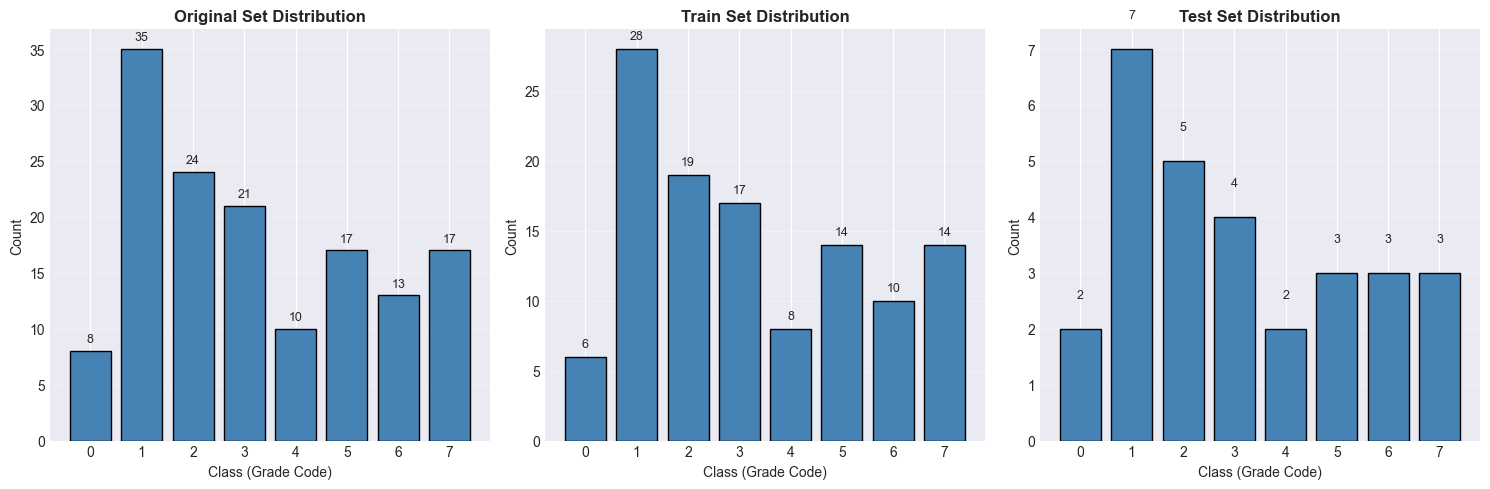


✅ Distribusi kelas seimbang di train dan test set!
✅ Grafik disimpan di: results/figures/distribution_plots/


In [15]:
print("\n" + "="*80)
print("VERIFIKASI STRATIFIED SPLIT")
print("="*80)

print("\n📊 Distribusi kelas di setiap split:\n")

# Hitung distribusi
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index() * 100
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index() * 100
total_dist = pd.Series(y_encoded).value_counts(normalize=True).sort_index() * 100

# Buat dataframe perbandingan
comparison_df = pd.DataFrame({
    'Original (%)': total_dist,
    'Train (%)': train_dist,
    'Test (%)': test_dist
}).round(2)

print(comparison_df)

# Visualisasi distribusi
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot untuk setiap split
splits = [('Original', y_encoded), ('Train', y_train), ('Test', y_test)]
for idx, (name, data) in enumerate(splits):
    dist = pd.Series(data).value_counts().sort_index()
    
    axes[idx].bar(range(len(dist)), dist.values, color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{name} Set Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class (Grade Code)', fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].set_xticks(range(len(dist)))
    axes[idx].set_xticklabels(dist.index)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Tambahkan nilai di atas bar
    for i, v in enumerate(dist.values):
        axes[idx].text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/distribution_plots/train_test_split_distribution.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Distribusi kelas seimbang di train dan test set!")
print("✅ Grafik disimpan di: results/figures/distribution_plots/")

In [16]:
print("\n" + "="*80)
print("STEP 5: FEATURE SCALING (STANDARDIZATION)")
print("="*80)

print("\n🔧 Menggunakan StandardScaler (Z-score normalization)")
print("💡 Formula: z = (x - mean) / std")
print("💡 Alasan: PENTING untuk SVM karena sensitive terhadap scale!\n")

# Inisialisasi scaler
scaler = StandardScaler()

# Fit scaler hanya pada training data (PENTING!)
scaler.fit(X_train)

# Transform train dan test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame untuk readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Feature scaling berhasil!")


STEP 5: FEATURE SCALING (STANDARDIZATION)

🔧 Menggunakan StandardScaler (Z-score normalization)
💡 Formula: z = (x - mean) / std
💡 Alasan: PENTING untuk SVM karena sensitive terhadap scale!

✅ Feature scaling berhasil!



VERIFIKASI FEATURE SCALING

📊 Statistik SEBELUM scaling (Training Set):
      STUDENT ID      1      2      3      4      5      6      7      8  \
mean      72.922  1.603  1.621  1.931  3.578  1.672  1.638  1.586  1.621   
std       43.023  0.603  0.487  0.539  0.825  0.471  0.483  0.495  0.984   

          9  ...     22     23     24     25     26     27     28     29  \
mean  1.560  ...  1.250  1.388  1.155  2.569  2.043  2.388  1.828  3.086   
std   1.015  ...  0.435  0.656  0.409  0.531  0.665  0.586  0.837  1.329   

         30  COURSE ID  
mean  2.741      4.181  
std   0.915      3.227  

[2 rows x 32 columns]

📊 Statistik SETELAH scaling (Training Set):
      STUDENT ID      1      2      3      4      5      6      7      8  \
mean       0.000  0.000  0.000 -0.000  0.000  0.000 -0.000 -0.000  0.000   
std        1.004  1.004  1.004  1.004  1.004  1.004  1.004  1.004  1.004   

          9  ...     22     23     24     25     26     27     28     29  \
mean -0.000  ... -0.0

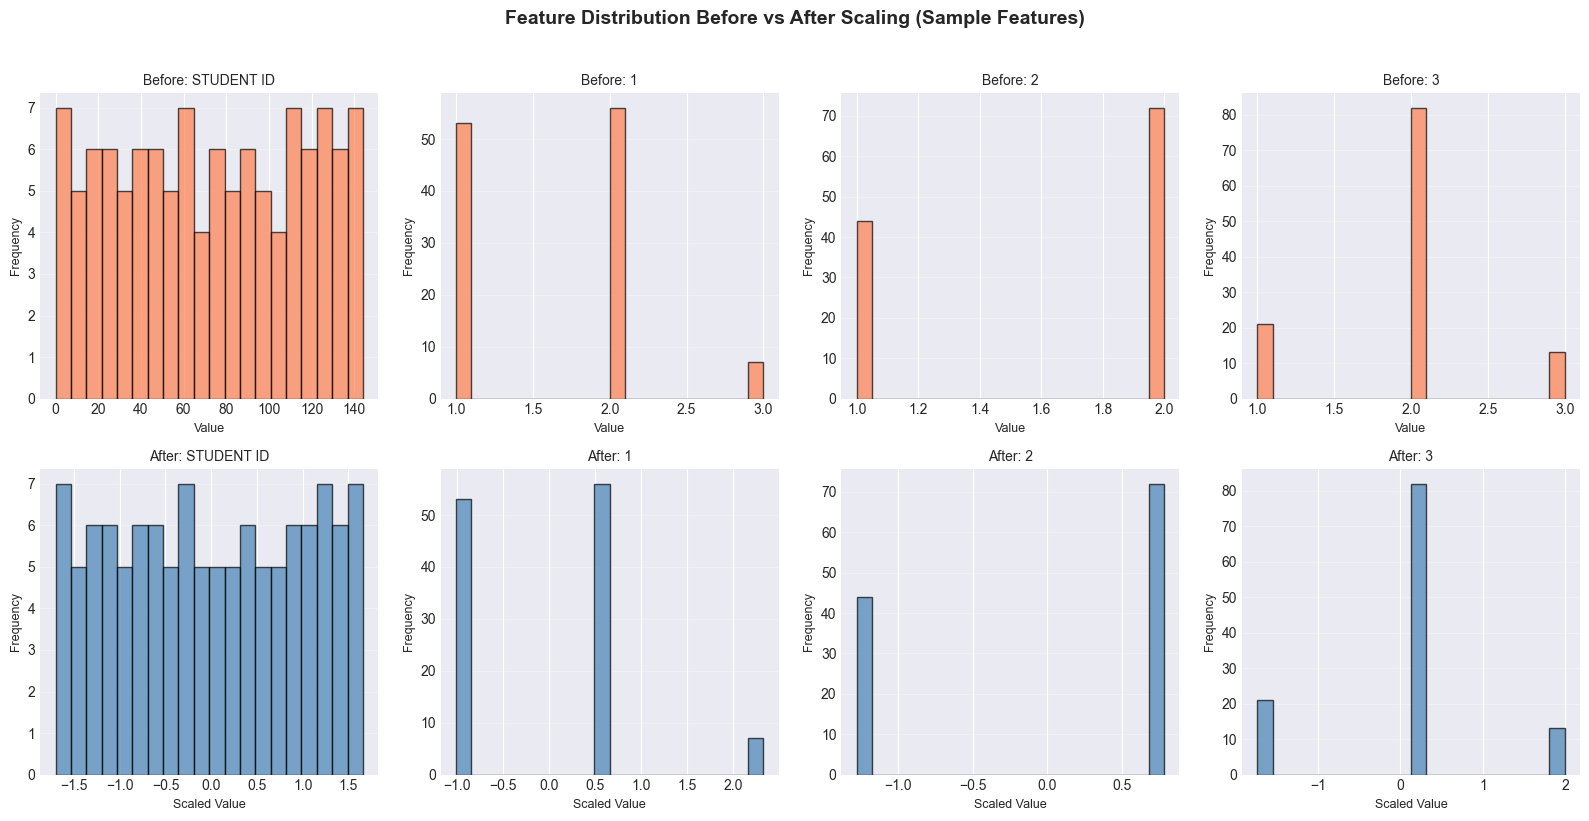


✅ Visualisasi scaling disimpan!


In [17]:
print("\n" + "="*80)
print("VERIFIKASI FEATURE SCALING")
print("="*80)

print("\n📊 Statistik SEBELUM scaling (Training Set):")
print(X_train.describe().loc[['mean', 'std']].round(3))

print("\n📊 Statistik SETELAH scaling (Training Set):")
print(X_train_scaled.describe().loc[['mean', 'std']].round(3))

print("\n💡 Setelah scaling, mean ≈ 0 dan std ≈ 1 untuk semua features")

# Visualisasi perbandingan distribusi (ambil 4 features acak)
sample_features = X_train.columns[:4].tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, feature in enumerate(sample_features):
    # Before scaling
    axes[0, idx].hist(X_train[feature], bins=20, color='coral', edgecolor='black', alpha=0.7)
    axes[0, idx].set_title(f'Before: {feature}', fontsize=10)
    axes[0, idx].set_xlabel('Value', fontsize=9)
    axes[0, idx].set_ylabel('Frequency', fontsize=9)
    axes[0, idx].grid(axis='y', alpha=0.3)
    
    # After scaling
    axes[1, idx].hist(X_train_scaled[feature], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1, idx].set_title(f'After: {feature}', fontsize=10)
    axes[1, idx].set_xlabel('Scaled Value', fontsize=9)
    axes[1, idx].set_ylabel('Frequency', fontsize=9)
    axes[1, idx].grid(axis='y', alpha=0.3)

plt.suptitle('Feature Distribution Before vs After Scaling (Sample Features)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/figures/distribution_plots/feature_scaling_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualisasi scaling disimpan!")

In [18]:
print("\n" + "="*80)
print("SUMMARY PREPROCESSING")
print("="*80)

summary = {
    'Original Dataset Size': df.shape[0],
    'After Cleaning': len(X_encoded),
    'Missing Values Handled': 'Yes' if missing_before > 0 else 'No Missing',
    'Duplicates Removed': duplicates_before,
    'Total Features': X_encoded.shape[1],
    'Numeric Features': len(numeric_features),
    'Categorical Features Encoded': len(categorical_features),
    'Target Encoded': 'Yes',
    'Train Set Size': len(X_train),
    'Test Set Size': len(X_test),
    'Feature Scaling': 'StandardScaler',
    'Stratified Split': 'Yes'
}

print("\n📋 Ringkasan Preprocessing:")
for key, value in summary.items():
    print(f"  • {key}: {value}")



SUMMARY PREPROCESSING

📋 Ringkasan Preprocessing:
  • Original Dataset Size: 145
  • After Cleaning: 145
  • Missing Values Handled: No Missing
  • Duplicates Removed: 0
  • Total Features: 32
  • Numeric Features: 31
  • Categorical Features Encoded: 1
  • Target Encoded: Yes
  • Train Set Size: 116
  • Test Set Size: 29
  • Feature Scaling: StandardScaler
  • Stratified Split: Yes


In [19]:
print("\n" + "="*80)
print("MENYIMPAN DATA YANG SUDAH DIPROSES")
print("="*80)

# Simpan data cleaned (sebelum split)
df_cleaned = X_encoded.copy()
df_cleaned[target_col] = y_encoded
df_cleaned.to_csv('../data/processed/data_cleaned.csv', index=False)
print("✅ Data cleaned disimpan: data/processed/data_cleaned.csv")

# Simpan train-test split (belum scaled - untuk tree-based models)
np.savez('../data/processed/train_test_split.npz',
         X_train=X_train.values,
         X_test=X_test.values,
         y_train=y_train.values,
         y_test=y_test.values)
print("✅ Train-test split (unscaled) disimpan: data/processed/train_test_split.npz")

# Simpan scaled data (untuk SVM dan model sensitive terhadap scale)
np.savez('../data/processed/train_test_split_scaled.npz',
         X_train_scaled=X_train_scaled.values,
         X_test_scaled=X_test_scaled.values,
         y_train=y_train.values,
         y_test=y_test.values)
print("✅ Train-test split (scaled) disimpan: data/processed/train_test_split_scaled.npz")

# Simpan scaler dan encoders
preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'feature_names': X_train.columns.tolist(),
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'target_column': target_col
}

with open('../data/processed/preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)
print("✅ Preprocessing objects disimpan: data/processed/preprocessing_objects.pkl")


MENYIMPAN DATA YANG SUDAH DIPROSES
✅ Data cleaned disimpan: data/processed/data_cleaned.csv
✅ Train-test split (unscaled) disimpan: data/processed/train_test_split.npz
✅ Train-test split (scaled) disimpan: data/processed/train_test_split_scaled.npz
✅ Preprocessing objects disimpan: data/processed/preprocessing_objects.pkl


In [20]:
print("\n" + "="*80)
print("VERIFIKASI FILE YANG TERSIMPAN")
print("="*80)

import os

files_to_check = [
    '../data/processed/data_cleaned.csv',
    '../data/processed/train_test_split.npz',
    '../data/processed/train_test_split_scaled.npz',
    '../data/processed/preprocessing_objects.pkl',
    '../data/processed/metadata.pkl'
]

print("\n📁 File yang tersimpan:")
for file_path in files_to_check:
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"  ✅ {file_path.split('/')[-1]} ({file_size:.2f} KB)")
    else:
        print(f"  ❌ {file_path.split('/')[-1]} - NOT FOUND!")


VERIFIKASI FILE YANG TERSIMPAN

📁 File yang tersimpan:
  ✅ data_cleaned.csv (9.77 KB)
  ✅ train_test_split.npz (38.36 KB)
  ✅ train_test_split_scaled.npz (38.39 KB)
  ✅ preprocessing_objects.pkl (3.55 KB)
  ✅ metadata.pkl (0.29 KB)


In [21]:
print("\n" + "="*80)
print("QUICK TEST - LOAD SAVED DATA")
print("="*80)

# Test load scaled data
test_data = np.load('../data/processed/train_test_split_scaled.npz')
print("\n✅ Test loading scaled data:")
print(f"  • X_train_scaled shape: {test_data['X_train_scaled'].shape}")
print(f"  • X_test_scaled shape: {test_data['X_test_scaled'].shape}")
print(f"  • y_train shape: {test_data['y_train'].shape}")
print(f"  • y_test shape: {test_data['y_test'].shape}")

# Test load preprocessing objects
with open('../data/processed/preprocessing_objects.pkl', 'rb') as f:
    test_objects = pickle.load(f)
print("\n✅ Test loading preprocessing objects:")
print(f"  • Scaler: {type(test_objects['scaler']).__name__}")
print(f"  • Features: {len(test_objects['feature_names'])} features")
print(f"  • Target column: {test_objects['target_column']}")

# %% [markdown]
# ## KESIMPULAN TAHAP 2
# 
# Preprocessing berhasil diselesaikan dengan hasil:
# 1. ✅ Data Cleaning: Missing values & duplikat ditangani
# 2. ✅ Feature Engineering: Encoding kategorikal dengan Label Encoding
# 3. ✅ Target Encoding: Grade di-encode secara ordinal
# 4. ✅ Train-Test Split: 80-20 dengan stratified sampling
# 5. ✅ Feature Scaling: StandardScaler untuk SVM
# 6. ✅ Data Saved: Siap untuk modeling
# 
# **Data yang tersimpan:**
# - `data_cleaned.csv`: Dataset bersih (full)
# - `train_test_split.npz`: Train-test unscaled (untuk RF, KNN, ANN)
# - `train_test_split_scaled.npz`: Train-test scaled (untuk SVM)
# - `preprocessing_objects.pkl`: Scaler & encoders
# 
# **NEXT STEP:** Modeling - Baseline Models (KNN, Random Forest, ANN)

print("\n" + "="*80)
print("✅ TAHAP 2 SELESAI - DATA PREPROCESSING COMPLETED!")
print("="*80)
print("\n🚀 Lanjut ke TAHAP 3: Baseline Models (KNN, RF, ANN)")
print("\n💡 TIP: Data sudah siap untuk modeling!")
print("     • Gunakan data UNSCALED untuk: KNN, Random Forest, ANN")
print("     • Gunakan data SCALED untuk: SVM")


QUICK TEST - LOAD SAVED DATA

✅ Test loading scaled data:
  • X_train_scaled shape: (116, 32)
  • X_test_scaled shape: (29, 32)
  • y_train shape: (116,)
  • y_test shape: (29,)

✅ Test loading preprocessing objects:
  • Scaler: StandardScaler
  • Features: 32 features
  • Target column: GRADE

✅ TAHAP 2 SELESAI - DATA PREPROCESSING COMPLETED!

🚀 Lanjut ke TAHAP 3: Baseline Models (KNN, RF, ANN)

💡 TIP: Data sudah siap untuk modeling!
     • Gunakan data UNSCALED untuk: KNN, Random Forest, ANN
     • Gunakan data SCALED untuk: SVM
